In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [401]:
def add_perspective_effect_left(image, intensity=0.5):
    """
    Warps the perspective of the image to make lines converge faster towards a point on the left side.
    
    Args:
    - image: A numpy array representing the input image.
    - intensity: A float representing how intense the effect should be.
                 The higher the number, the closer the perspective point will appear on the left side.
                 
    Returns:
    - The image with the modified perspective.
    """
    h, w = image.shape[:2]
    # Define the points to map from the source image
    src_points = np.float32([[0, 0], [w, 0], [0, h], [w, h]])
    
    # Calculate the displacement of the side points based on the intensity
    displacement = h * intensity
    
    # Define the points to map to on the destination image
    # Move the right side upwards and the left side downwards
    dst_points = np.float32([[0, displacement], [w, 0], [0, h - displacement], [w, h]])
    
    # Compute the perspective transform matrix
    matrix = cv2.getPerspectiveTransform(src_points, dst_points)
    
    # Apply the perspective transformation to the image
    warped_image = cv2.warpPerspective(image, matrix, (w, h))
    
    return warped_image


def add_perspective_effect(image, intensity=0.5):
    """
    Warps the perspective of the image to make lines converge faster towards the horizon.
    
    Args:
    - image: A numpy array representing the input image.
    - intensity: A float representing how intense the effect should be.
                 The higher the number, the closer the perspective point will appear.
                 
    Returns:
    - The image with the modified perspective.
    """
    h, w = image.shape[:2]
    # Define the points to map from the source image
    src_points = np.float32([[0, 0], [w, 0], [0, h], [w, h]])
    
    # Calculate the displacement of the top edge points based on the intensity
    displacement = w * intensity
    
    # Define the points to map to on the destination image
    dst_points = np.float32([[displacement, 0], [w - displacement, 0], [0, h], [w, h]])
    
    # Compute the perspective transform matrix
    matrix = cv2.getPerspectiveTransform(src_points, dst_points)
    
    # Apply the perspective transformation to the image
    warped_image = cv2.warpPerspective(image, matrix, (w, h))
    
    return warped_image

# Example usage:
# image is a numpy array representing your image
# intensity is a float; higher values intensify the effect


def overlay_images(image1, image2, premute=True):
    # Assuming both images are PyTorch tensors and have the same dimensions
    # Convert both images to the same scale (0, 1)
    image1 = (image1 - image1.min()) / (image1.max() - image1.min())
    image2 = (image2 - image2.min()) / (image2.max() - image2.min())
    
    if image2.shape[2] == 3:
        image2 = (image2 * 255).astype(np.uint8)
        # convert to grayscale
        image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    # Overlay the images by averaging them
    # weher image1 has a postive value make image2 0
    image2[image1 > 0] = 0

    
    # Convert to numpy for plotting
    if premute:
        overlayed_image = overlayed_image.permute(1, 2, 0).numpy()
    
    # Display the overlayed image
    plt.imshow(image2)
    plt.show()


# Now pool the edge maps values with a 3x3 kernel

def pool_edge_map(edge_map, pool_size=3):
    # Define the kernel
    kernel = np.ones((pool_size, pool_size), np.float32) / (pool_size ** 2)
    
    # Perform the pooling
    pooled_edge_map = cv2.filter2D(edge_map, -1, kernel)
    
    return pooled_edge_map

def get_edge_map(rgb_image):
    # First, check if the image loading was successful
    if rgb_image is None:
        raise ValueError("Image not loaded. Please check the file path.")
    
    if rgb_image.min() < 0:
        rgb_image = (rgb_image + 1) / 2  # Rescales data from [-1, 1] to [0, 1]
    
    # Ensure the image is a uint8 numpy array with values in [0, 255]
    if rgb_image.dtype != np.uint8:
        # Assuming the image is in [0, 1], scale to [0, 255]. Adjust as needed.
        rgb_image = (rgb_image * 255).astype(np.uint8)
    
    
    # Check if the image is already grayscale
    if len(rgb_image.shape) == 2:
        gray_image = rgb_image  # The image is already grayscale
    else:
        # Convert the image to grayscale as Canny edge detection expects a single channel image
        gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY)
    
    # Use Canny edge detection
    # The thresholds can be tuned for your specific images
    edges = cv2.Canny(gray_image, threshold1=160, threshold2=260)

    
    return edges

def resize_image(image, target_size = (512,320)):
    # Resize the image to the target size
    resized_image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
    
    return resized_image    

def zoom_out_and_shift(image, scale_factor, target_size, shift_down, shift_left):
    try:
        # Resize the image to a smaller size
        smaller_image = cv2.resize(image, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_AREA)
        
        # Calculate padding size
        pad_top = (target_size[0] - smaller_image.shape[0]) // 2 + shift_down
        pad_bottom = (target_size[0] - smaller_image.shape[0]) // 2 - shift_down
        pad_left = (target_size[1] - smaller_image.shape[1]) // 2 + shift_left
        pad_right = (target_size[1] - smaller_image.shape[1]) // 2 - shift_left
        
        # Ensure that padding values are non-negative
        pad_top = max(pad_top, 0)
        pad_bottom = max(pad_bottom, 0)
        pad_left = max(pad_left, 0)
        pad_right = max(pad_right, 0)
        
        # Pad the smaller image to make it the same size as the target size
        padded_image = cv2.copyMakeBorder(smaller_image, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
        
        # If the target size has odd dimensions or due to shifts, we might be off by a few pixels, so adjust as necessary
        padded_image = padded_image[:target_size[0], :target_size[1]]
    except:
        return np.zeros(target_size)
    return padded_image

def get_mass_center(numpy_array):
    width, height = numpy_array.shape
    counter = 0
    sum_x = 0
    sum_y = 0
    for x in range(width):
        for y in range(height):
            # Get the value
            value = numpy_array[x, y]
            if value > 0:
                # Add to the sum
                sum_x += x
                sum_y += y
                counter += 1
            

            # Center of mass
    return (sum_x / counter, sum_y / counter)


# Create a function that corrups random patches constent over the batch dimension
def corrupt_random_patch_batch(images, patch_size=50):
    # Get the image dimensions
    batch_size, channels,  width, height = images.shape
    
    # Copy the image
    corrupted_images = np.copy(images)
    
    # Randomly select the top-left corner of the patch
    top_left_x = np.random.randint(0, width - patch_size, batch_size)
    top_left_y = np.random.randint(0, height - patch_size, batch_size)
    
    # Corrupt the patch by setting it to zero
    for i in range(batch_size):
        corrupted_images[i, top_left_x[i]:top_left_x[i] + patch_size, top_left_y[i]:top_left_y[i] + patch_size] = 0
    
    return corrupted_images
def corrupt_random_patch(image, patch_size=50):
    # Get the image dimensions
    width, height = image.shape
    
    # Copy the image
    corrupted_image = np.copy(image)
    
    # Randomly select the top-left corner of the patch
    top_left_x = np.random.randint(0, width - patch_size)
    top_left_y = np.random.randint(0, height - patch_size)
    
    # Corrupt the patch by setting it to zero
    corrupted_image[top_left_x:top_left_x + patch_size, top_left_y:top_left_y + patch_size] = 0
    
    return corrupted_image


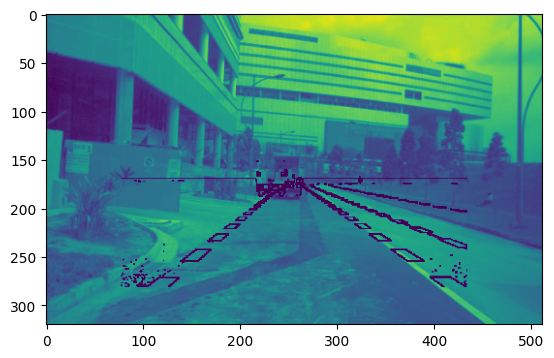

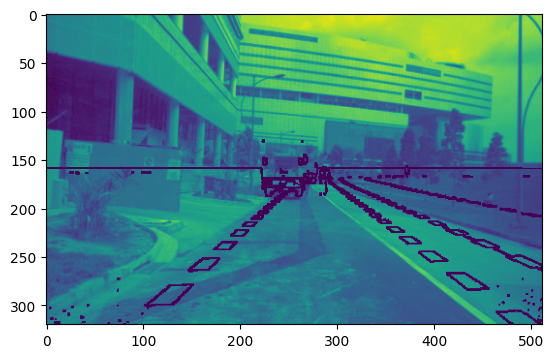

In [408]:
# Alligining images 
# load json file
import json
import os
import numpy as np

# Load the JSON file
json_file = '/home/wisley/custom_diffusers_library/src/diffusers/jasper/complete_data_paths.json'  # Replace with your JSON file path
with open(json_file, 'r') as f:
    data = json.load(f)

scene = 4
frame = 10
rgb_image = data['ground_truth'][scene][frame]  # Replace with your edge-detected image path
edge_image = data['conditioning_images_two'][scene][frame]      # Replace with your photograph image path


# conver image ot edge_map 
rgb_edge_image = cv2.imread(rgb_image)
edge_image  = cv2.imread(edge_image)

# conver the edge map to grayscale
edge_image = cv2.cvtColor(edge_image, cv2.COLOR_BGR2GRAY)

# Get the edge map for the photograph
rgb_edge_map = get_edge_map(rgb_edge_image)

# Rezie the edge map to the same size as the photograph
resize_edge = resize_image(edge_image)
resized_rgb = resize_image(rgb_edge_map)
normal = resize_image(rgb_edge_image)


# pool the edge map
pooled_edge = pool_edge_map(resize_edge, pool_size=1)


# # Zoom out and shift the edge map to align with the photograph
# mass_zoomed = get_mass_center(pooled_edge[150:,:])
# mass_pooled = get_mass_center(pooled_rgb[150:,:])
# shift_x = mass_pooled[0] - mass_zoomed[0]
# shift_y = mass_pooled[1] - mass_zoomed[1]
# print(shift_x, shift_y)

shift_y = np.clip(shift_y, -50, 50)

zoomed_edge = zoom_out_and_shift(pooled_edge, scale_factor=0.7, target_size=(320,512), shift_down=10, shift_left=0)
zoomed_edge_2 = zoom_out_and_shift(pooled_edge, scale_factor=1, target_size=(320,512), shift_down=0, shift_left=0)
# visualizing the edge map
# plt.figure(figsize=(15, 15))
# plt.imshow(pooled_edge_map, cmap='gray')

intensified_image = add_perspective_effect_left(zoomed_edge_2, intensity=-0.1)

# Overlay the edge map on the photograph
overlay_images(zoomed_edge, normal, premute=False)
overlay_images(intensified_image, normal, premute=False)
# overlay_images(resize_edge, resized_rgb, premute=False)


In [396]:
intensified_image = add_perspective_effect(zoomed_edge_2, intensity=0.2)


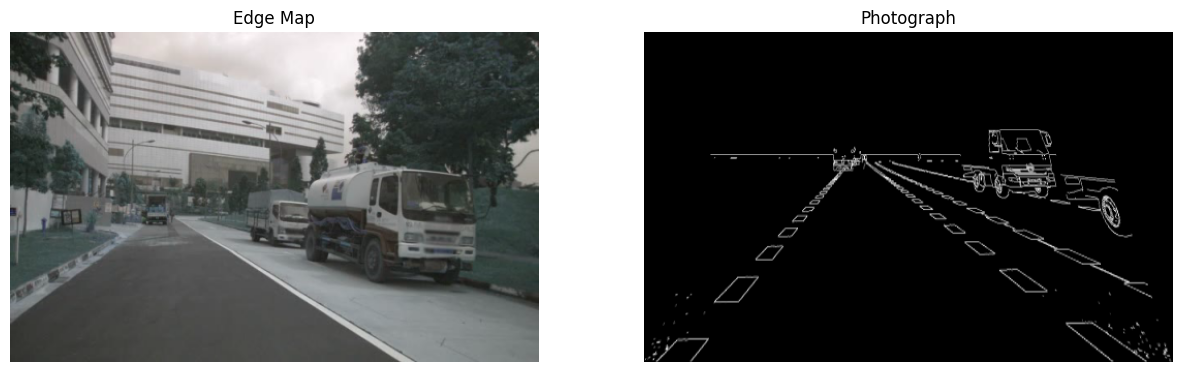

In [397]:
# create two plots next to each other one shwoing the zoomed_edge the other the pooled rgb
fig, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].imshow(normal, cmap='gray')
axs[0].set_title('Edge Map')
axs[0].axis('off')

axs[1].imshow(intensified_image, cmap='gray')
axs[1].set_title('Photograph')
axs[1].axis('off')






plt.show()